# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Efficient_Net_Unfreeze")
mlflow.set_tag("mlflow.runName", "Version 1")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_Efficient_Net')

2025/06/24 17:30:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)

        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [7]:
print(len(data))

178


In [8]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [9]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [10]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

143
35


In [11]:
train_dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [12]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([16, 3, 300, 300])
torch.Size([16])


# Function to Load Pre-trained Model from Pytorch

In [13]:
def create_model():
    # Load EfficientNet-B3 with pretrained weights
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    num_classes = 4

    # UnFreeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Replace the last layer (classifier[1]) to match num_classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # Unfreeze just the new classifier layer
    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model

In [14]:
# Add checkpoint to model
from torch.utils.checkpoint import checkpoint_sequential
class EfficientNetCheckpointed(nn.Module):
    def __init__(self, model, num_segments=8):  # You can tune this
        super().__init__()
        self.stem = model.features[0]  # First block (usually Conv + BN + SiLU)
        
        # Wrap remaining blocks in Sequential to use checkpoint_sequential
        self.blocks = nn.Sequential(*model.features[1:])
        
        self.num_segments = num_segments  # for checkpointing
        self.avgpool = model.avgpool
        self.classifier = model.classifier

    def forward(self, x):
        x = self.stem(x)
        
        # Apply checkpointing across MBConv blocks
        x = checkpoint_sequential(self.blocks, self.num_segments, x, use_reentrant=False)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
model = EfficientNetCheckpointed(model = create_model())
model.to(DEVICE)

EfficientNetCheckpointed(
  (stem): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAc

In [16]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Model training

In [18]:
num_epochs = 100
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], [] 
train_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
validation_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    train_accuracy_obj.reset()

    # its not acutally each image here but a batch of images instead (batch size = 16 so 16 images)
    for image_batch, label_batch in tqdm(train_dataloader, desc = "Training loop"):
        images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images) # logits output
        loss = criterion(outputs, labels) # logits output can work directly with labels
        train_accuracy_obj.update(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_acc = train_accuracy_obj.compute()
    train_accuracy.append(train_acc)

    #Validation phase
    model.eval()
    running_loss = 0.0
    validation_accuracy_obj.reset()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            validation_accuracy_obj.update(outputs, labels)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_acc = validation_accuracy_obj.compute()
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s , Train accuracy: %s , Validation accuracy: %s " % (epoch + 1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_loss, 
                                                                                                                         val_loss,
                                                                                                                         train_acc,
                                                                                                                         val_acc))

Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 100 - Train loss: 1.3468867660908217 , Validation loss: 1.213157037326268 , Train accuracy: tensor(0.2890, device='cuda:0') , Validation accuracy: tensor(0.7064, device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 100 - Train loss: 1.1606439901201913 , Validation loss: 1.025537942137037 , Train accuracy: tensor(0.6435, device='cuda:0') , Validation accuracy: tensor(0.9167, device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 100 - Train loss: 1.0102571664231548 , Validation loss: 0.8432375192642212 , Train accuracy: tensor(0.7615, device='cuda:0') , Validation accuracy: tensor(0.9583, device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 100 - Train loss: 0.8414645797750923 , Validation loss: 0.6840845916952406 , Train accuracy: tensor(0.8597, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 100 - Train loss: 0.6416584079185229 , Validation loss: 0.4846977846963065 , Train accuracy: tensor(0.9657, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 100 - Train loss: 0.50161343745971 , Validation loss: 0.3467449588435037 , Train accuracy: tensor(0.9677, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 100 - Train loss: 0.36539836412065485 , Validation loss: 0.22100197332245963 , Train accuracy: tensor(0.9861, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 100 - Train loss: 0.28508691171581824 , Validation loss: 0.14090208624090467 , Train accuracy: tensor(0.9744, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 100 - Train loss: 0.18542695179414215 , Validation loss: 0.08110126278230122 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 100 - Train loss: 0.1255502694108513 , Validation loss: 0.051798444773469655 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 100 - Train loss: 0.12296381659722061 , Validation loss: 0.03896464726754597 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 100 - Train loss: 0.09811042098516828 , Validation loss: 0.020409582555294035 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 100 - Train loss: 0.10190599888898014 , Validation loss: 0.015312669106892177 , Train accuracy: tensor(0.9857, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 100 - Train loss: 0.043875348283333726 , Validation loss: 0.012609478272497653 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 100 - Train loss: 0.06424078495984667 , Validation loss: 0.009156106957899673 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 100 - Train loss: 0.05626567042945476 , Validation loss: 0.007619760584618364 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 100 - Train loss: 0.06925378413347716 , Validation loss: 0.01021395561152271 , Train accuracy: tensor(0.9861, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 100 - Train loss: 0.050699447899052265 , Validation loss: 0.008802382514945098 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 100 - Train loss: 0.06490401408812974 , Validation loss: 0.006334271148911544 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 100 - Train loss: 0.06331652587049463 , Validation loss: 0.008168443398816245 , Train accuracy: tensor(0.9836, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 100 - Train loss: 0.06758729343333941 , Validation loss: 0.006622578336724213 , Train accuracy: tensor(0.9837, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 100 - Train loss: 0.043725746317525925 , Validation loss: 0.007628296807940517 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 100 - Train loss: 0.027193343957488455 , Validation loss: 0.006839712343311735 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 100 - Train loss: 0.03518824312794075 , Validation loss: 0.0036410016672951836 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 100 - Train loss: 0.020943484781833176 , Validation loss: 0.0047969526744314605 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 100 - Train loss: 0.023894310960274064 , Validation loss: 0.005748683294015271 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 100 - Train loss: 0.03573826365591435 , Validation loss: 0.0032944090398294586 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 100 - Train loss: 0.011992447894443287 , Validation loss: 0.002051675958292825 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 100 - Train loss: 0.012742048610797089 , Validation loss: 0.002252607445033001 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 100 - Train loss: 0.03166697582418329 , Validation loss: 0.001566015775980694 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 100 - Train loss: 0.01971981804190057 , Validation loss: 0.0020212335445519004 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 100 - Train loss: 0.023624008584223435 , Validation loss: 0.002177484787534922 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 100 - Train loss: 0.018760676715481147 , Validation loss: 0.0018969988583454065 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 100 - Train loss: 0.031037106837951734 , Validation loss: 0.00220651059145374 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 100 - Train loss: 0.018816136660870543 , Validation loss: 0.0013119512154454631 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 100 - Train loss: 0.02555455784365702 , Validation loss: 0.0015666622834812317 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 100 - Train loss: 0.02023530751466751 , Validation loss: 0.001928164131407227 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 100 - Train loss: 0.008824587914715992 , Validation loss: 0.0014408145199662874 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 100 - Train loss: 0.010861485233802474 , Validation loss: 0.00143484742147848 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 100 - Train loss: 0.012725146968712967 , Validation loss: 0.0016755999431812337 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 100 - Train loss: 0.011715530867824394 , Validation loss: 0.0013270607118361763 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 100 - Train loss: 0.029668636274722854 , Validation loss: 0.0011396757792681456 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 100 - Train loss: 0.03470744412350521 , Validation loss: 0.0010193777752907148 , Train accuracy: tensor(0.9931, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 100 - Train loss: 0.031005486176255044 , Validation loss: 0.0008680822244579239 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 100 - Train loss: 0.027696999961907946 , Validation loss: 0.0007391463840446834 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 100 - Train loss: 0.00946597729840975 , Validation loss: 0.0007655731186137668 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 100 - Train loss: 0.01270226255226671 , Validation loss: 0.0006168870887319957 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 100 - Train loss: 0.02099527046084404 , Validation loss: 0.0007541281437235219 , Train accuracy: tensor(0.9882, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 100 - Train loss: 0.03218366904707437 , Validation loss: 0.0006254206810678755 , Train accuracy: tensor(0.9865, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 100 - Train loss: 0.03164487730795413 , Validation loss: 0.0013713140689235713 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 100 - Train loss: 0.017126968465326877 , Validation loss: 0.002539007631795747 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 100 - Train loss: 0.027492542238382812 , Validation loss: 0.001989859136353646 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 100 - Train loss: 0.012949801228019628 , Validation loss: 0.0016445843203525459 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 100 - Train loss: 0.014803357673495004 , Validation loss: 0.0012314900818247614 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 100 - Train loss: 0.011427706128425813 , Validation loss: 0.0008853858769206064 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 100 - Train loss: 0.014241891546865528 , Validation loss: 0.0007671730260231665 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 100 - Train loss: 0.035382020046536844 , Validation loss: 0.00046455915185755916 , Train accuracy: tensor(0.9865, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 100 - Train loss: 0.01092049591452553 , Validation loss: 0.0011429793716940496 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 100 - Train loss: 0.021499147764250135 , Validation loss: 0.0013356525583990983 , Train accuracy: tensor(0.9931, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 100 - Train loss: 0.010787899658251344 , Validation loss: 0.001194255577865988 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 100 - Train loss: 0.03919540552861905 , Validation loss: 0.0007452329504303634 , Train accuracy: tensor(0.9857, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 100 - Train loss: 0.008878377025549332 , Validation loss: 0.000934356331293072 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 100 - Train loss: 0.011407530730527438 , Validation loss: 0.0007883456203022173 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 100 - Train loss: 0.041567213236867046 , Validation loss: 0.0005884066182521305 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 100 - Train loss: 0.018029606430215783 , Validation loss: 0.003912156660641943 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 100 - Train loss: 0.05908917922401027 , Validation loss: 0.0026086878098015276 , Train accuracy: tensor(0.9885, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 100 - Train loss: 0.030021664299321977 , Validation loss: 0.0015790038941694156 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 100 - Train loss: 0.01675271941872125 , Validation loss: 0.001554387980805976 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 100 - Train loss: 0.011886510119009553 , Validation loss: 0.0009737724704401834 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 100 - Train loss: 0.009965216291001004 , Validation loss: 0.0013402887753077915 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 100 - Train loss: 0.028293485198630376 , Validation loss: 0.0005828245443158916 , Train accuracy: tensor(0.9931, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 100 - Train loss: 0.01222282944226198 , Validation loss: 0.0005959457002713211 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 100 - Train loss: 0.006170943703795417 , Validation loss: 0.0004939286429102399 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 100 - Train loss: 0.021037821218455106 , Validation loss: 0.0005183674187199878 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 100 - Train loss: 0.018711403158775876 , Validation loss: 0.0007468364642201257 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 100 - Train loss: 0.02990089471483331 , Validation loss: 0.0006846640375442803 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 100 - Train loss: 0.031731431351535104 , Validation loss: 0.0005652492217320417 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 100 - Train loss: 0.02107466376397047 , Validation loss: 0.0008954300578417522 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 100 - Train loss: 0.016629426719181325 , Validation loss: 0.0004958178548674498 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 100 - Train loss: 0.006632784936116652 , Validation loss: 0.00040230051215205874 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 100 - Train loss: 0.014553707323214982 , Validation loss: 0.0004975015380685883 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 100 - Train loss: 0.007733547092111928 , Validation loss: 0.0004640636599755713 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 100 - Train loss: 0.007300996812834834 , Validation loss: 0.00040100586234724945 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 100 - Train loss: 0.01160969737959042 , Validation loss: 0.0003103066767965044 , Train accuracy: tensor(0.9932, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 100 - Train loss: 0.013524420533245533 , Validation loss: 0.00031879926599296077 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 100 - Train loss: 0.015779669009400216 , Validation loss: 0.0004170018564244466 , Train accuracy: tensor(0.9931, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 100 - Train loss: 0.008868924666489109 , Validation loss: 0.0003303562110106993 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 100 - Train loss: 0.008520181112912265 , Validation loss: 0.0003135877727930035 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 100 - Train loss: 0.009186666908809978 , Validation loss: 0.00026222913022918095 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 100 - Train loss: 0.00980718212013834 , Validation loss: 0.00018531463824079505 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 100 - Train loss: 0.006171523572437549 , Validation loss: 0.0002822741279877456 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 100 - Train loss: 0.003411715520608626 , Validation loss: 0.0003097255152949531 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 100 - Train loss: 0.004315926450084937 , Validation loss: 0.00016256212256848812 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 100 - Train loss: 0.007179231688987171 , Validation loss: 0.00017991018872375467 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 100 - Train loss: 0.0023419152490083087 , Validation loss: 0.00013060797718935646 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 100 - Train loss: 0.0027288489718659877 , Validation loss: 0.0002371260834999183 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 100 - Train loss: 0.018143694180723154 , Validation loss: 0.00014492458597357784 , Train accuracy: tensor(0.9865, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 100 - Train loss: 0.011745996161081483 , Validation loss: 0.0003610191155790484 , Train accuracy: tensor(1., device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 100 - Train loss: 0.02226931790120146 , Validation loss: 0.0004884806528155293 , Train accuracy: tensor(0.9953, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 100 - Train loss: 0.009066104219200906 , Validation loss: 0.00044442901375337635 , Train accuracy: tensor(0.9952, device='cuda:0') , Validation accuracy: tensor(1., device='cuda:0') 


# Visualize

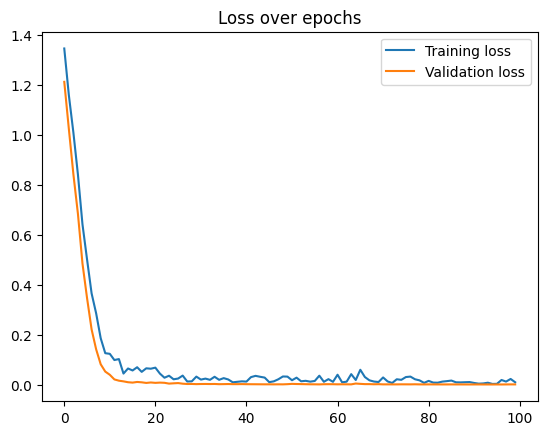

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [24]:
print(train_accuracy[0].)

tensor(0.2890, device='cuda:0')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

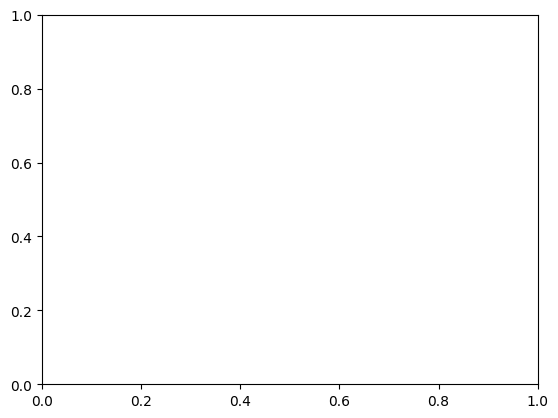

In [20]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Test Model with Seperated Test Data

In [ ]:
def predict(model, image_path):
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil).unsqueeze(0).to(DEVICE) #Already transformed into a tensor here

    model.eval()
    with torch.no_grad():
        predictions_logits = model(image_tensor)
        max_logits_predicted, max_logits_index = torch.max(predictions_logits, dim=1)
    return max_logits_index.item()

In [ ]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
predicted, ground_truth = [], []
for style in os.listdir(TEST_FOLDER_DIR):
    correct_result = CLASSIFICATION_MAPPING[style]
    style_path = os.path.join(TEST_FOLDER_DIR, style)
    for pic in os.listdir(style_path):
        predicted_result = predict(model, os.path.join(style_path, pic))
        predicted.append(predicted_result)
        ground_truth.append(correct_result)

# Model Evaluation Logging

In [ ]:
# Log result
for category, accuracy in zip(categories, accuracies):
    mlflow.log_metric(category.replace("'", "").replace("{","").replace("}","").replace(": ", "").replace(", ", " "), accuracy)